In [1]:
import math
import os
import sys
sys.path.insert(0,'../src/')
import matplotlib.colors as colors
import matplotlib.pyplot as plt
import pandas as pd
from pandas.plotting import register_matplotlib_converters
import seaborn as sns
from database import SQLiteDatabase
from experiment import preliminary_setup

In [2]:
KWARGS = preliminary_setup()
plt.rcParams['axes.xmargin'] = 0
plt.rcParams['axes.ymargin'] = 0
register_matplotlib_converters()
DB_DIRECTORY = KWARGS['database_directory']
MISC_DIRECTORY = KWARGS['misc_directory']
SUMMARY_DIRECTORY = KWARGS['summary_directory']
FIGURES_DIRECTORY = KWARGS['figure_directory']
DATABASE = SQLiteDatabase(os.path.join(DB_DIRECTORY,'rbc_validation.db'))
GRID = DATABASE.get_table('grid')
SIMULATION_IDS = GRID['simulation_id'].unique()

# measured battery data
MEASURED_DATA = pd.read_csv(os.path.join(KWARGS['misc_directory'],'battery_electricity_consumption.csv'))
MEASURED_DATA.columns = ['timestamp','building_id','actual_electrical_storage_electricity_consumption']
MEASURED_DATA['timestamp'] = pd.to_datetime(MEASURED_DATA['timestamp'])

# Get measured battery data

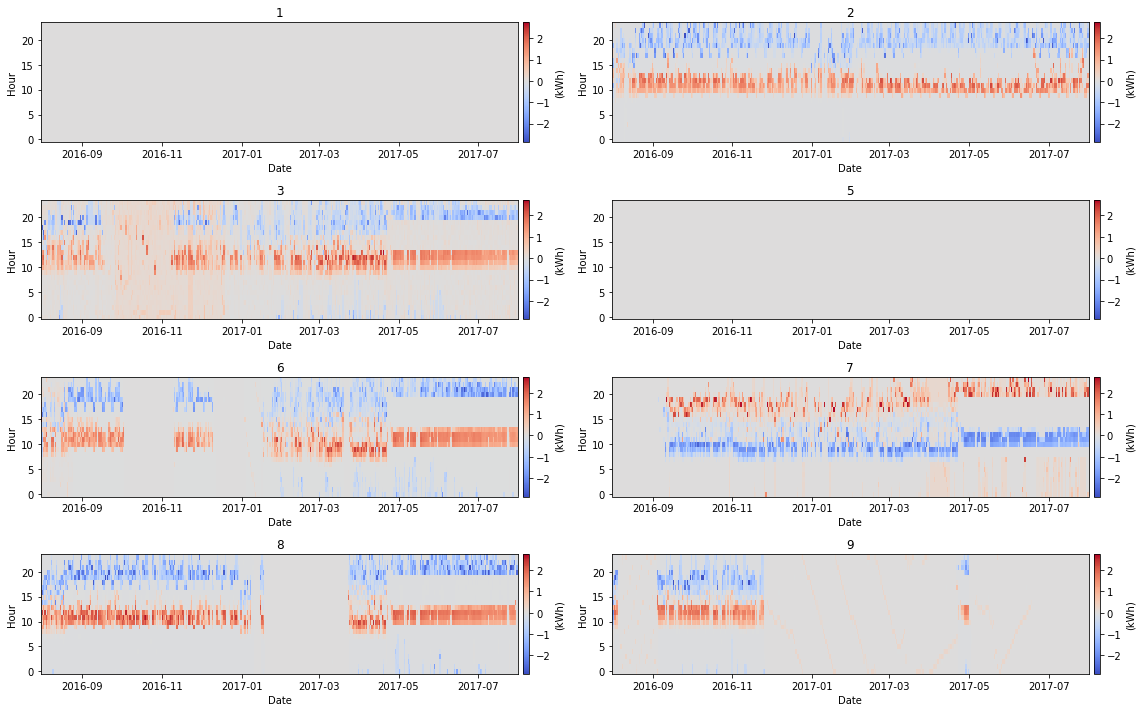

In [4]:
cmap = 'coolwarm'
plot_data = MEASURED_DATA.copy()
plot_data['date'] = plot_data['timestamp'].dt.normalize()
plot_data['hour'] = plot_data['timestamp'].dt.hour
column_count_limit = 2
row_count = math.ceil(len(plot_data['building_id'].unique())/column_count_limit)
column_count = min(column_count_limit,len(plot_data['building_id'].unique()))
fig, axs = plt.subplots(row_count, column_count, figsize=(8*column_count,2.5*row_count))
vmin, vmax = plot_data['actual_electrical_storage_electricity_consumption'].min(), plot_data['actual_electrical_storage_electricity_consumption'].max()
vcenter = 0.0
vmin = -0.99 if vcenter <= vmin else vmin
vmax = 1.01 if vcenter >= vmax else vmax

for ax, (building_id, b_data) in zip(fig.axes, plot_data.groupby('building_id')):
    b_data = b_data.pivot(index='hour',columns='date',values='actual_electrical_storage_electricity_consumption')
    x, y, z = b_data.columns, b_data.index, b_data.values
    divnorm = colors.TwoSlopeNorm(vcenter=vcenter,vmin=vmin,vmax=vmax)
    pcm = ax.pcolormesh(x,y,z,shading='nearest',cmap=cmap,norm=divnorm,edgecolors='black',linewidth=0.0)
    _ = fig.colorbar(pcm,ax=ax,orientation='vertical',label='(kWh)',fraction=0.025,pad=0.01)
    ax.tick_params('x',which='both',rotation=0)
    ax.set_xlabel('Date')
    ax.set_ylabel('Hour')
    ax.set_title(building_id)

plt.tight_layout()
plt.savefig(os.path.join(FIGURES_DIRECTORY,f'measured_battery_electricity_consumption.pdf'),bbox_inches='tight',transparent=True)
plt.show()

- The measured battery data is an aggregation of all battery submeters in each building as some buildings may hae more than 1 battery that operate at different times.
- The figure above shows that although batteries are installed in 8 buildings, only buildings 2, 3, 6, 7, 8 and 9 actually have them operational. 
- The battery in building 1 never gets used.
- The data for the battery in building 5 is faulty because all it does it charge and never discharges.
- Since there are days in most buildings where the battery consumption is 0 all through, such days should be excluded when calculating the error as CityLearn simulation will still simulate battery usage on those days.


In [5]:
VALID_BUILDING_IDS = [2,3,6,7,8,9]

# Calculate consumption error

In [6]:
measured_data = MEASURED_DATA.copy()
measured_data['date'] = measured_data['timestamp'].dt.normalize()

# only select valid buildings first
measured_data = measured_data[measured_data['building_id'].isin(VALID_BUILDING_IDS)].copy() 

# remove days in measured data that are just zeros all through
temp_data = measured_data.copy()
temp_data['actual_electrical_storage_electricity_consumption'] = temp_data['actual_electrical_storage_electricity_consumption'].abs()
temp_data = temp_data.groupby(['building_id','date'])['actual_electrical_storage_electricity_consumption'].sum().reset_index()
temp_data['valid_day'] = True
temp_data.loc[temp_data['actual_electrical_storage_electricity_consumption']<=1.0, 'valid_day'] = False
temp_data = temp_data.drop(columns=['actual_electrical_storage_electricity_consumption'])
summary = temp_data.groupby(['building_id','valid_day']).size().reset_index(name='count')
summary = summary.pivot(index='building_id',columns='valid_day',values='count').fillna(0).astype(int)
temp_data = temp_data[temp_data['valid_day']==True].copy()
measured_data = measured_data.merge(temp_data,on=['building_id','date'],how='inner')
display(summary)

valid_day,False,True
building_id,,
2,10,355
3,7,358
6,92,273
7,51,314
8,81,284
9,272,93


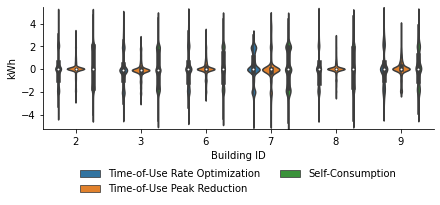

building_id                            rbc     error                      \
                                                    min       max      mean   
0            2               Self-Consumption -4.081497  4.759894  0.106609   
1            2     Time-of-Use Peak Reduction -2.708771  3.213545  0.031740   
2            2  Time-of-Use Rate Optimization -3.957796  4.829581  0.062366   
3            3               Self-Consumption -4.612817  4.499164 -0.046056   
4            3     Time-of-Use Peak Reduction -2.837223  2.654783 -0.105292   
5            3  Time-of-Use Rate Optimization -4.117880  4.654728 -0.074670   
6            6               Self-Consumption -4.384184  4.448704  0.064216   
7            6     Time-of-Use Peak Reduction -2.522034  3.302012 -0.002412   
8            6  Time-of-Use Rate Optimization -4.308584  4.820390  0.028418   
9            7               Self-Consumption -4.731743  4.395347  0.134441   
10           7     Time-of-Use Peak Reduction -4.700565  4.557373  0.062618   
11           7  Time-of-Use Rate Optimization -4.734646  2.965896  0.092545   
12           8               Self-Consumption -4.583636  4.713817  0.077507   
13           8     Time-of-Use Peak Reduction -2.355642  2.774810  0.011438   
14           8  Time-of-Use Rate Optimization -4.086663  4.847600  0.042240   
15           9               Self-Consumption -3.957200  4.702529  0.069881   
16           9     Time-of-Use Peak Reduction -2.069492  3.781842  0.014280   
17           9  Time-of-Use Rate Optimization -3.879831  4.817700  0.046889   

              
         std  
0   1.644450  
1   0.702701  
2   1.453942  
3   1.536190  
4   0.777319  
5   1.442594  
6   1.579219  
7   0.720070  
8   1.517822  
9   1.735246  
10  1.360968  
11  1.316040  
12  1.627342  
13  0.647239  
14  1.573364  
15  1.484794  
16  0.789682  
17  1.514386

In [9]:
query = f"""
SELECT
    g.type AS rbc,
    t.timestamp,
    t.building_id,
    t.electrical_storage_electricity_consumption
FROM detailed_summary t
LEFT JOIN grid g ON g.simulation_id = t.simulation_id
WHERE t.building_id IN {tuple(VALID_BUILDING_IDS)}
"""
rbc_map = {
    'agent.SelfConsumptionFontanaRBC':'Self-Consumption', 
    'agent.TOUPeakReductionFontanaRBC':'Time-of-Use Peak Reduction',
    'agent.TOURateOptimizationFontanaRBC':'Time-of-Use Rate Optimization',
}
data = DATABASE.query_table(query)
data['rbc'] = data['rbc'].map(lambda x: rbc_map[x])
data['timestamp'] = pd.to_datetime(data['timestamp'])
data = data.merge(measured_data,on=['building_id','timestamp'],how='inner')
data['error'] = data['electrical_storage_electricity_consumption'] - data['actual_electrical_storage_electricity_consumption']
summary = data.groupby(['building_id','rbc'])[['error']].agg([min,max,'mean','std']).reset_index()
fig, ax = plt.subplots(1,1,figsize=(7.0,2.25))
sns.violinplot(x='building_id',y='error',data=data,hue='rbc')
ax.legend(
    loc='lower center',
    bbox_to_anchor=(0.5,-0.6),
    framealpha=0,
    ncol=min(2,len(rbc_map))
)
ax.set_xlabel('Building ID')
ax.set_ylabel('kWh')
ax.set_xticklabels([l.get_text().split('_')[-1] for l in ax.get_xticklabels()])

for s in ['right','top']:
    ax.spines[s].set_visible(False)

# plt.tight_layout()
plt.savefig(os.path.join(FIGURES_DIRECTORY,f'rbc_validation.pdf'),bbox_inches='tight',transparent=True)
plt.show()

display(summary)

- While all three RBC strategies have their median at 0, the `Time-of-Use Peak Reduction` RBC strategy has most of its error values distributed around 0 i.e. has less variance compared to the other 2. In all buildings but building 9, the distribution of overestimated and underestimated consumption are similar. In building 9, overestimation is more prevalent compared to underestimation.